In [1]:
# 🔧 Add root to sys.path for module imports (Jupyter-safe)
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent  # Go up from /notebooks/ → experiment → project root
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"[INFO] Added ROOT to sys.path: {ROOT}")


[INFO] Added ROOT to sys.path: /home/arsalan/wsu-grid/ml-jet-param-predictor


In [2]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.training_loop import run_training_loop
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.scheduler_utils import create_scheduler
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [3]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/config/vit_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_25072401_hybrid_mamaba_vit_statck/config/hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")
# cfg=get_config()
# print(cfg)
print(json.dumps(vars(cfg), indent=2))


[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/config/vit_bs512_ep50_lr1e-04_ds1000.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Extracted dataset_size from path: 1000
{
  "model_tag": "ViT_tiny_patch16_224_augreg_in21k_ft_in1k",
  "backbone": "vit_augreg_in21k_ft_in1k",
  "batch_size": 32,
  "epochs": 12,
  "learning_rate": 0.0001,
  "patience": 3,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled",
  "train_csv": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.

In [4]:
device = get_device_summary()

=== NVIDIA-SMI ===
Thu Jul 24 15:55:34 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   38C    P5              25W / 220W |   2409MiB /  8192MiB |     28%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [5]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using ViT model: vit_tiny_patch16_224.augreg_in21k_ft_in1k, pretrained: True


ViTClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none

In [6]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 25
[INFO] Length of validation dataloader: 3
[INFO] Length of test dataloader: 4


In [7]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [8]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [9]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [10]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [11]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json


In [12]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [13]:
best_epoch,best_acc,best_metrics=run_training_loop(
                      cfg,train_loader,val_loader,
                      device, model,criterion,
                      optimizer,scheduler,
                      start_epoch,early_stop_counter,
                      best_acc,best_metrics,best_epoch,
                      train_loss_list,
                        train_loss_energy_list,
                        train_loss_alpha_list,
                        train_loss_q0_list,
                        train_acc_list,
                        train_acc_energy_list,
                        train_acc_alpha_list,
                        train_acc_q0_list,
                        val_loss_list,
                        val_loss_energy_list,
                        val_loss_alpha_list,
                        val_loss_q0_list,
                        val_acc_list,
                        val_acc_energy_list,
                        val_acc_alpha_list,
                        val_acc_q0_list,
                        all_epoch_metrics)

[INFO] Epoch 1/12


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3542, Q0 Acc = 0.2500, Total Acc = 0.0938
[INFO] Epoch 1: Energy Loss =0.5579, αs Loss = 1.1116, Q0 Loss = 1.4539, Total Loss = 3.1234
📉 Current LR: 0.0001
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
✅ Best model saved at epoch 1 with total accuracy: 0.0938
[INFO] Epoch 2/12


[INFO] Epoch 2: Energy Acc =0.7500, αs Acc = 0.4583, Q0 Acc = 0.2917, Total Acc = 0.1042
[INFO] Epoch 2: Energy Loss =0.5479, αs Loss = 1.0550, Q0 Loss = 1.3706, Total Loss = 2.9735
📉 Current LR: 0.0001
[INFO] Epoch 2: Saving metrics to disk
💾 Last model saved at epoch 2
✅ Best model saved at epoch 2 with total accuracy: 0.1042
[INFO] Epoch 3/12


[INFO] Epoch 3: Energy Acc =0.7604, αs Acc = 0.4375, Q0 Acc = 0.2812, Total Acc = 0.1042
[INFO] Epoch 3: Energy Loss =0.5017, αs Loss = 1.0504, Q0 Loss = 1.3976, Total Loss = 2.9498
📉 Current LR: 0.0001
[INFO] Epoch 3: Saving metrics to disk
💾 Last model saved at epoch 3
⏳ No improvement. Early stop counter: 1/3
[INFO] Epoch 4/12


[INFO] Epoch 4: Energy Acc =0.7917, αs Acc = 0.3750, Q0 Acc = 0.3542, Total Acc = 0.0833
[INFO] Epoch 4: Energy Loss =0.4688, αs Loss = 1.0665, Q0 Loss = 1.3775, Total Loss = 2.9127
📉 Current LR: 0.0001
[INFO] Epoch 4: Saving metrics to disk
💾 Last model saved at epoch 4
⏳ No improvement. Early stop counter: 2/3
[INFO] Epoch 5/12


[INFO] Epoch 5: Energy Acc =0.7604, αs Acc = 0.3229, Q0 Acc = 0.3021, Total Acc = 0.0521
[INFO] Epoch 5: Energy Loss =0.4843, αs Loss = 1.1160, Q0 Loss = 1.3667, Total Loss = 2.9670
📉 Current LR: 0.0001
[INFO] Epoch 5: Saving metrics to disk
💾 Last model saved at epoch 5
⏳ No improvement. Early stop counter: 3/3
🛑 Early stopping triggered at epoch 5. Best was at epoch 2.


In [14]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json

🏁 Best Model @ Epoch 2
Total Accuracy: 0.1042

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.4583
  Precision: 0.4855
  Recall   : 0.4583
  F1-Score : 0.4218

🔹 Q0 Task
  Accuracy : 0.2917
  Precision: 0.2449
  Recall   : 0.2917
  F1-Score : 0.2513


📊 Plots saved to:
 - training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.png
 - training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.pdf


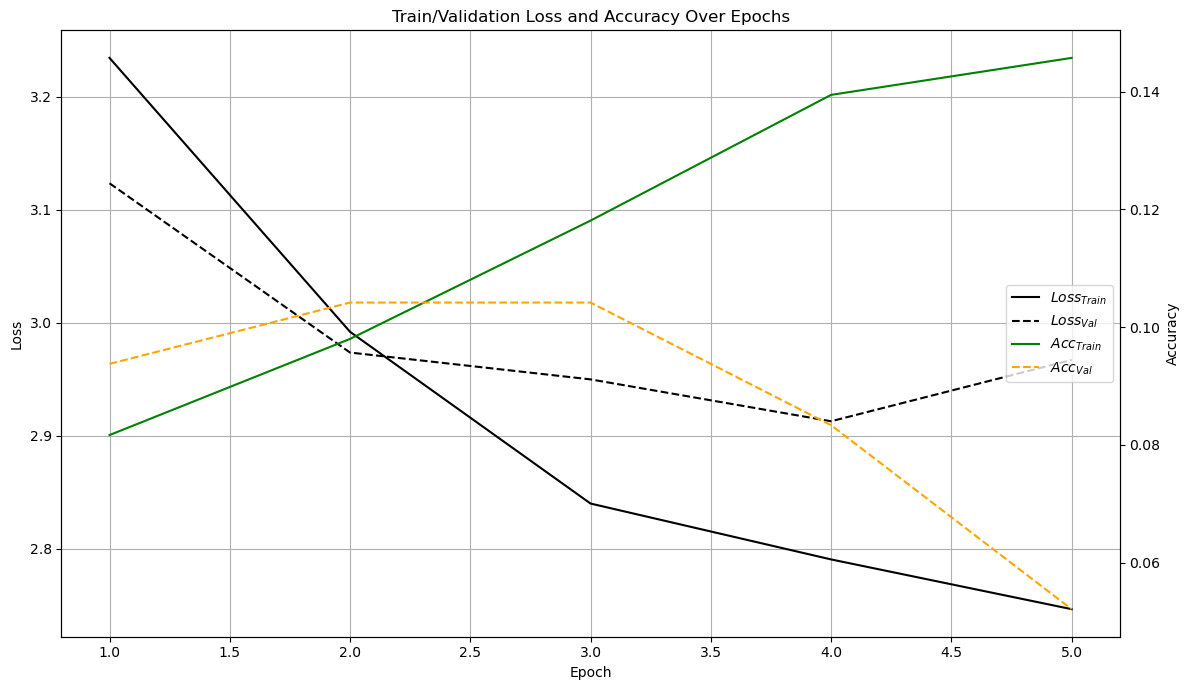

📉 Loss plot saved as:
  - training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.pdf


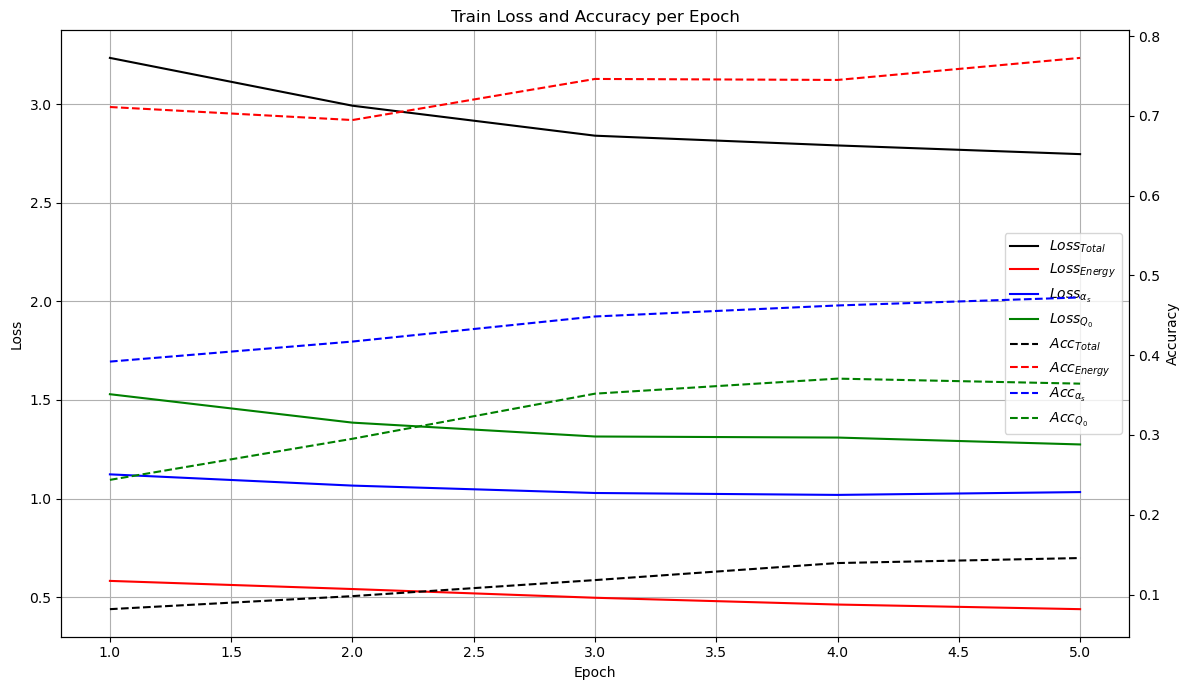

📉 Loss plot saved as:
  - training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/ViT_tiny_patch16_224_augreg_in21k_ft_in1k_bs32_ep12_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.pdf


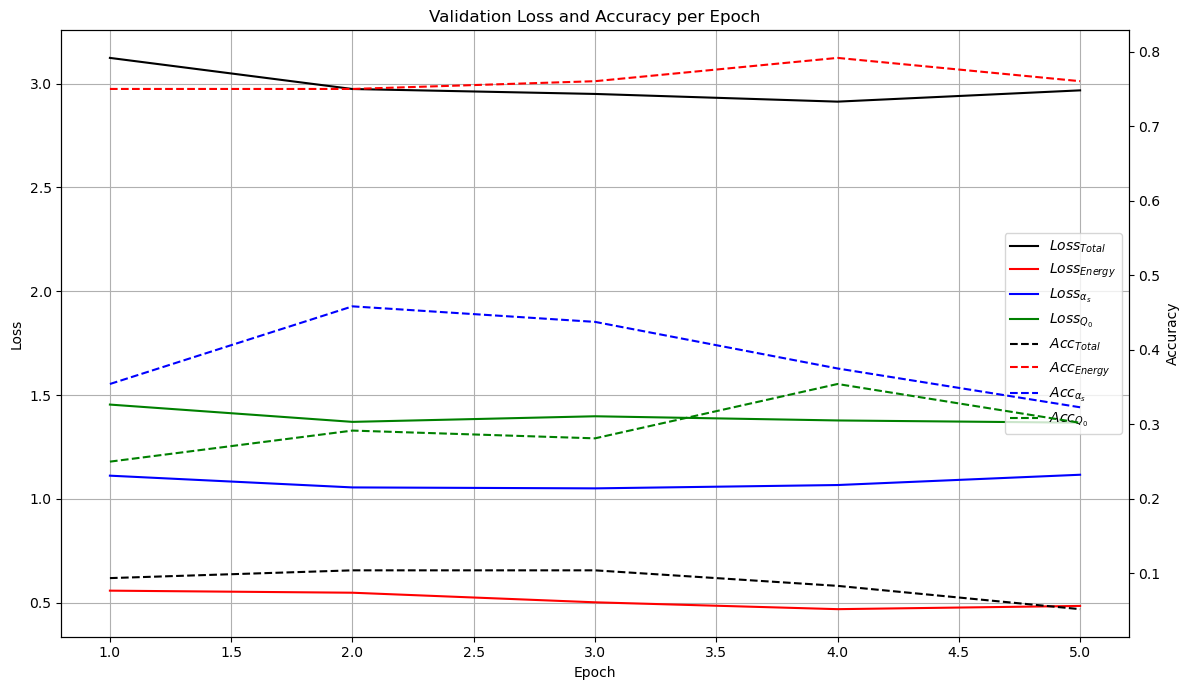

In [15]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")